## TTT4275 Classification Project: Music Classification

In [1]:
# Imports
import source.data_handling
import source.mappings
import source.plotting
import source.diy_classifiers

import numpy as np


In [2]:
# Load the dataset and split into training and test
# X = M x N dataset with M samples of N features

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_set = source.data_handling.read_genre_class_data(data_version)

features = source.mappings.MUSIC_FEATURES_ALL

training_data, test_data = source.data_handling.prepare_data(
        data_frame=data_set,
        features=features,
    )
print(len(features))
print(training_data.y)
print(type(data_set))

63
0       pop
1       pop
2       pop
3       pop
4       pop
       ... 
787    jazz
788    jazz
789    jazz
790    jazz
791    jazz
Name: Genre, Length: 792, dtype: object
<class 'pandas.core.frame.DataFrame'>


In [3]:
print(source.data_handling.GENRE_CLASS_DATA_30S)
print(source.data_handling._file_path)

c:\Users\Ivan\OneDrive - NTNU\Desktop\V22\EDC\ttt4275-music-classification\source\..\resources\data\GenreClassData_30s.txt
c:\Users\Ivan\OneDrive - NTNU\Desktop\V22\EDC\ttt4275-music-classification\source


## Task 1 Plots

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


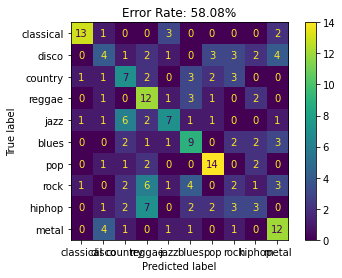

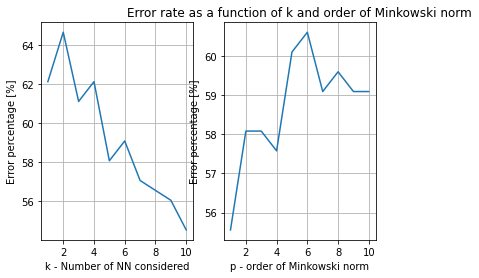

In [4]:
# kNN parameters
k = 5
features_task_1 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]

ks = np.arange(10) + 1
ps = np.arange(10) + 1

print(ks)
print(ps)


y_pred_task1 = source.diy_classifiers.kNN(k, training_data, test_data, p=2)
y_true_task1 = test_data.y

source.plotting.confusion_matrix(y_true_task1, y_pred_task1)
source.plotting.error_rates_vs_params(ks, ps, training_data, test_data)


## Task 2 Plots


In [ ]:
# Crazy code

## Task 3 Plots

In [ ]:
# Crazy code

## Task 4 plots

In [ ]:
# Crazy code